In [1]:
import numpy as np 
from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt 
from numba import njit
plt.rcParams['figure.figsize'] = [16, 9]

In [2]:
fs = 44100 
fc = 2000
k_data = 500
k_coeff = 128
N_taps = 8

[0.01797909 0.06198747 0.16622539 0.25380804 0.25380804 0.16622539
 0.06198747 0.01797909]
[ 2  7 21 32 32 21  7  2]
[ 1  6 21 35 35 21  6  1]


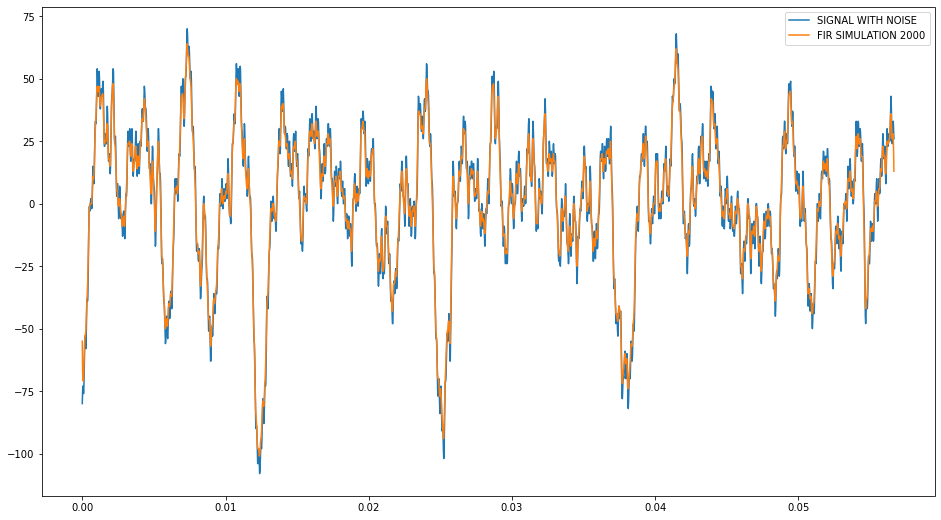

In [3]:
B = np.loadtxt("BET.txt", delimiter=",")
t = B[:2500,0] # take the first 2500
x = B[:2500,1] # input double

xc = x + 0.01*np.sin(2*np.pi*7000*t) # input corr double
xc_int = (k_data*xc).astype(int) # input corr int (rescaled)

coeffs2000 = firwin(numtaps=N_taps, cutoff=2000, fs=fs, pass_zero="lowpass")# calcoliamo i coefficienti del FIR
print(coeffs2000)
coeffs2000 = (k_coeff*coeffs2000).astype(int) #moltiplichiamo i coefficienti per k_coeff e poi li convertiamo in int
coeffs4000 = firwin(numtaps=N_taps, cutoff=4000, fs=fs, pass_zero="lowpass")# calcoliamo i coefficienti del FIR
coeffs4000 = (k_coeff*coeffs4000).astype(int) #moltiplichiamo i coefficienti per k_coeff e poi li convertiamo in int
print(coeffs2000)
print(coeffs4000)

def fir(input, coeffs, Nt) :
    output = np.zeros(input.shape[0])
    for n in range(7, len(output)) :
        for i in range(Nt) :
            output[n] += int(coeffs[i]*input[n-i])
    return output

xc_int_wb = np.concatenate((np.zeros(7), xc_int, np.zeros(4))).astype(int) # append 7 zeros at the begin and 4 to the end
# this is done in order to have the full output after the next shift
output_sim2000 = fir(xc_int_wb, coeffs2000, N_taps) # output sim double
output_sim2000 = output_sim2000[7+4:] # we discard the first 7 values and shift by 4
output_sim2000 /= k_coeff
output_sim_int2000 = output_sim2000.astype(int) # output sim int

output_sim4000 = fir(xc_int_wb, coeffs4000, N_taps) # output sim double
output_sim4000 = output_sim4000[7+4:] # we discard the first 7 values and shift by 4
output_sim4000 /= k_coeff
output_sim_int4000 = output_sim4000.astype(int) # output sim int

plt.plot(t,xc_int, label="SIGNAL WITH NOISE",zorder=1)
plt.plot(t,output_sim_int2000,label="FIR SIMULATION 2000",zorder=2)
plt.legend()

In [4]:
def frequency_spectrum(t, x, fs = None) :
    if fs is None :
        fs = 1/(np.diff(t).mean())
    a = np.abs(np.fft.fft(x))*2/len(x)
    a = a[0:len(a)//2]
    f = np.linspace(0,fs//2,len(a))
    return [f,a]

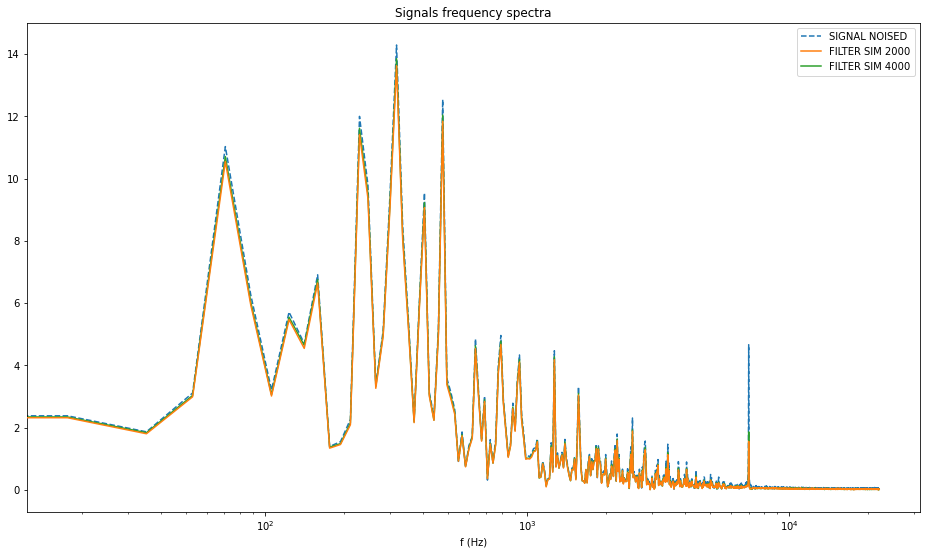

In [5]:
[f,ac] = frequency_spectrum(t, xc_int, fs = fs)
[_,ax] = frequency_spectrum(t, output_sim_int2000, fs = fs)
[_,ao] = frequency_spectrum(t, output_sim_int4000, fs = fs)

plt.plot(f,ac,"--",label="SIGNAL NOISED",zorder=1)
plt.plot(f,ax,label="FILTER SIM 2000",zorder=3)
plt.plot(f,ao,label="FILTER SIM 4000",zorder=2)

plt.xlabel("f (Hz)")
plt.title("Signals frequency spectra")
plt.xscale('log')
plt.legend(loc="upper right")

(2500,)


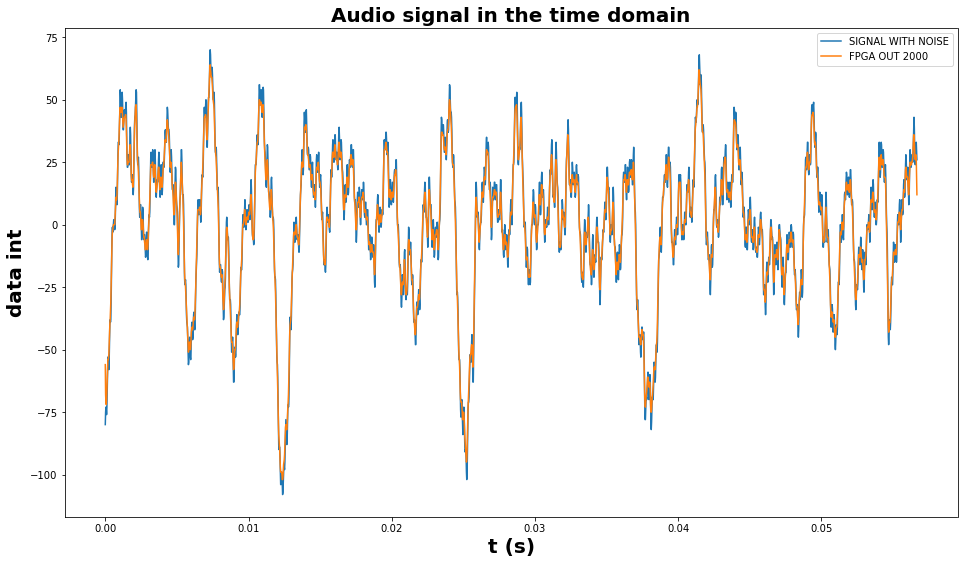

In [6]:
# THE SIGNAL GIVEN TO THE FPGA TESTBENCH IS np.concatenate((xc_int, np.zeros(4)))
output_fpga = np.loadtxt("output_results.txt")
output_fpga = output_fpga[4:]

print(output_fpga.shape)
plt.plot(t,xc_int, label = 'SIGNAL WITH NOISE')
plt.plot(t,output_fpga, label = 'FPGA OUT 2000')
plt.xlabel("t (s)",fontsize="20",fontweight="bold")
plt.ylabel("data int",fontsize="20",fontweight="bold")
plt.title("Audio signal in the time domain", fontsize="20",fontweight="bold");
plt.legend()
#plt.xlim(0,0.02)

<ipython-input-7-b6ec3694e677>:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,10000)


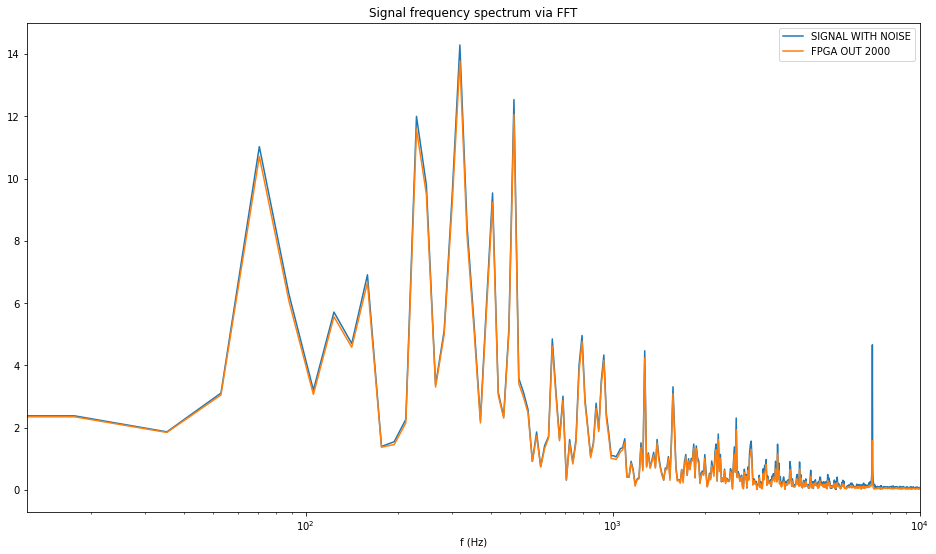

In [7]:
plt.plot(*frequency_spectrum(t,xc_int,fs=fs), label = 'SIGNAL WITH NOISE')
plt.plot(*frequency_spectrum(t,output_fpga,fs=fs),  label = 'FPGA OUT 2000')
plt.xscale('log')
plt.xlabel("f (Hz)")
plt.title("Signal frequency spectrum via FFT");
plt.xlim(0,10000)
plt.legend(loc="upper right")

-0.4324
0.49540916422690445


(array([   0.,    0.,    0., 1081., 1419.,    0.,    0.]),
 array([-4.5, -3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5]),
 <BarContainer object of 7 artists>)

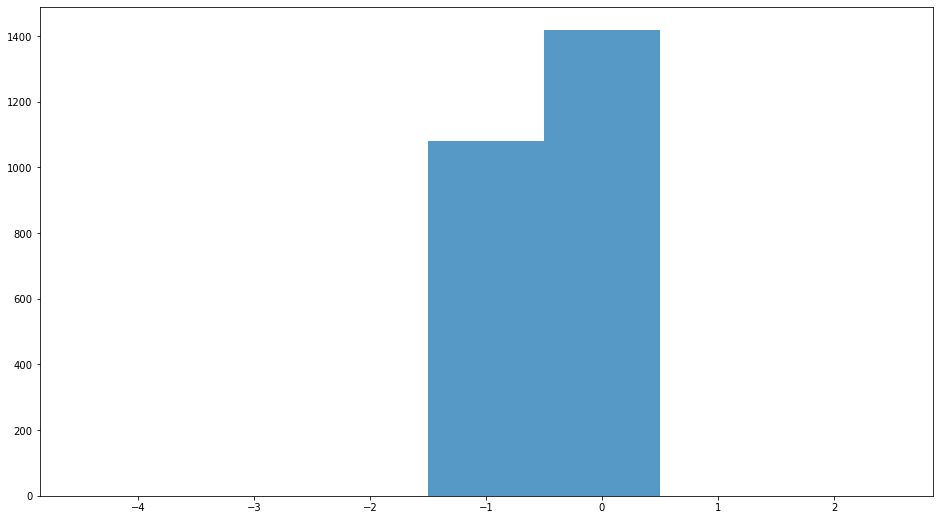

In [8]:
difference = output_fpga - output_sim_int2000
print(np.mean(difference))
print(np.std(difference))
plt.hist(difference, bins = [-4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5], alpha = 0.75)